<a href="https://colab.research.google.com/github/jdmartinev/ArtificialIntelligenceIM/blob/main/Lecture06/notebooks/L06_Autoencoder_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd '/content/drive/MyDrive/Courses/AI/Lecture06'

/content/drive/MyDrive/Courses/AI/Lecture06


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))

try:
    from plotting import plot_autoencoder_stats
except Exception as ex:
    print(f"If using Colab, you may need to upload `plotting.py`. \
          \nIn the left pannel, click `Files > upload to session storage` and select the file `plotting.py` from your computer \
          \n---------------------------------------------")
    print(ex)

# Aprendizaje No Supervisado

## Etiquetar Datos es Costoso

En el aprendizaje automático supervisado, el objetivo es aprender un mapeo $f_{\psi} : \mathbf{x} \in \mathcal{R}^P \rightarrow \mathbf{y}$ de observaciones $\mathbf{x}$ al objetivo $\mathbf{y}$ utilizando un conjunto de datos $\mathcal{D} = \{\mathbf{x}_i, \mathbf{y}_i\}_{i=1, \dots, N}$ de tamaño finito N (por ejemplo, clasificación de imágenes, traducción). Debido a la maldición de la dimensionalidad, las entradas de alta dimensión (imágenes) y los modelos complejos (aprendizaje profundo) requieren grandes conjuntos de datos (millones de pares $(\mathbf{x}, \mathbf{y})$). En la práctica, etiquetar datos es costoso (por ejemplo, marcar la presencia de cáncer en escaneos de rayos X).

## La Compresión es Comprensión: Aprendizaje sin Objetivo

Para superar la maldición de la dimensionalidad, nuestro objetivo es aprender una representación comprimida $\mathbf{z} \in \mathcal{R}^M$ de $\mathbf{x}$ tal que $M < P$ y exista un mapeo $g_{\phi}: \mathbf{x} \rightarrow \mathbf{z}$ que vincule cada punto de datos con su representación. Idealmente, $\mathbf{z}$ es un conjunto de características de baja dimensión que describe eficientemente a $\mathbf{x}$. Como ilustración, al modelar imágenes de celebridades (conjunto de datos CelebA), el conjunto de características faciales (color de ojos, edad, longitud del cabello, etc.) es una representación comprimida (y con pérdida) de $\mathbf{x}$. En la práctica, la representación $\mathbf{z}$ no es observable y [es poco probable que coincida con dichas características conocidas](https://arxiv.org/abs/1811.12359). Sin embargo, la representación $\mathbf{z}$ es de baja dimensión y aprender un mapeo $f_{\psi} : \mathbf{z} \in \mathcal{R}^M \rightarrow \mathbf{y}$ suele ser más fácil.

Mientras que etiquetar los datos es costoso, las observaciones $\mathbf{x}$ son baratas de adquirir. En muchos casos, se puede rastrear la web para recopilar una gran colección de imágenes o textos. Como resultado, se pueden desplegar grandes modelos de aprendizaje profundo para aprender $g_{\phi}$, y modelos más pequeños/eficientes en datos pueden aplicarse posteriormente para resolver la tarea supervisada.

# Autoencoders: Compresión como Proceso de Generación

En este cuaderno, implementarás un autoencoder (AE) simple. Suponemos que ya estás familiarizado con los conceptos básicos de las redes neuronales. Comenzaremos definiendo un AE similar al utilizado en la etapa de ajuste fino por [Geoffrey Hinton y Ruslan Salakhutdinov](https://www.cs.toronto.edu/~hinton/science.pdf). Experimentaremos con la configuración del AE e intentaremos ejecutarlo en el conjunto de datos MNIST. Ha habido una gran variedad de investigaciones en el campo de los autoencoders y la técnica que estás a punto de aprender es muy simple en comparación con los métodos modernos: Autoencoders enmascarados ([MADE](https://arxiv.org/abs/1502.03509), [BERT](https://arxiv.org/abs/1810.04805)) y Autoencoders Variacionales ([VAE](https://arxiv.org/abs/1312.6114), [VQ-VAE](https://arxiv.org/abs/1711.00937), [BIVA](https://arxiv.org/abs/1902.02102), [NVAE](https://arxiv.org/abs/2007.03898)).

En el aprendizaje no supervisado, nuestro objetivo es aprender representaciones comprimidas $\mathbf{z} \in \mathcal{P}$ de $\mathbf{x} \in \mathcal{R}$ donde $M < P$. La arquitectura de un autoencoder puede descomponerse en dos pasos:

1. *Codificación* de $\mathbf{x}$ en una representación de baja dimensión $\mathbf{z}$ usando una red neuronal $g_{\phi} : \mathbf{x} \rightarrow \mathbf{z}$.
2. *Decodificación* de la representación $\mathbf{z}$ en una reconstrucción $\hat{\mathbf{x}} = h_\theta(\mathbf{z}) \in \mathcal{R}^P$.

Dado que $M < P$, la codificación actúa como un cuello de botella de información: solo una parte de la información que describe $\mathbf{x}$ puede ser codificada en $\mathbf{z}$ siempre que $M$ sea lo suficientemente pequeño.

El aprendizaje de los parámetros del autoencoder depende de dos aspectos:

1. Una distancia en el espacio de observación $d : \mathcal{R}^{P} \times \mathcal{R}^{P} \rightarrow \mathcal{R}$ (por ejemplo, MSE), que mide la calidad de la reconstrucción.
2. Uso de retropropagación junto con descenso de gradiente estocástico (SGD) para optimizar los parámetros $\{\phi, \theta\}$ con respecto a $L := \frac{1}{N} \sum_i d(x_i, h_{\theta}(g_{\phi}(\mathbf{x})))$.

![Autoencoder](https://drive.google.com/uc?export=view&id=1PbaP-ROV8fkT8KeJ4v7dEcl5-4u8SLWO)

*Los ejercicios se encuentran al final del cuaderno.*


## MNIST

Primero, carguemos el conjunto de datos MNIST y dibujemos algunos ejemplos. En este cuaderno, utilizaremos los *dataloaders* y *datasets* proporcionados por PyTorch. Definir la carga de conjuntos de datos utilizando un *dataloader* tiene la ventaja de que solo carga los datos que son *necesarios* en la memoria, lo que nos permite utilizar conjuntos de datos a gran escala.

Cargaremos solo una cantidad limitada de clases definidas por la variable `classes` para acelerar el entrenamiento.


In [ ]:
import torch
cuda = torch.cuda.is_available()

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Flatten the 2d-array image into a vector
flatten = lambda x: ToTensor()(x).view(28**2)

# Define the train and test sets
dset_train = MNIST("./", train=True,  transform=flatten, download=True)
dset_test  = MNIST("./", train=False, transform=flatten)

# The digit classes to use
classes = [3, 7]

def stratified_sampler(labels, classes):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    from functools import reduce
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)


# The loaders perform the actual work
batch_size = 64
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.targets, classes), pin_memory=cuda)
test_loader  = DataLoader(dset_test, batch_size=batch_size,
                          sampler=stratified_sampler(dset_test.targets, classes), pin_memory=cuda)

### Construyendo el Modelo

Al definir el modelo, la capa latente $z$ debe actuar como un cuello de botella de información. Inicializamos el autoencoder (AE) con 1 capa oculta en el codificador y el decodificador utilizando unidades ReLU como funciones de no linealidad. La capa latente tiene una dimensionalidad de 2 para facilitar la visualización. Dado que $x$ son intensidades de píxeles que están normalizadas entre 0 y 1, utilizamos la función sigmoide como no linealidad para modelar la reconstrucción.


In [ ]:
import torch.nn as nn

# define size variables
num_features = 28*28

class AutoEncoder(nn.Module):
    def __init__(self, hidden_units, latent_features=2):
        super(AutoEncoder, self).__init__()
        # We typically employ an "hourglass" structure
        # meaning that the decoder should be an encoder
        # in reverse.

        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=hidden_units),
            nn.ReLU(),
            # bottleneck layer
            nn.Linear(in_features=hidden_units, out_features=latent_features)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_units),
            nn.ReLU(),
            # output layer, projecting back to image size
            nn.Linear(in_features=hidden_units, out_features=num_features)
        )

    def forward(self, x):
        outputs = {}
        # we don't apply an activation to the bottleneck layer
        z = self.encoder(x)

        # apply sigmoid to output to get pixel intensities between 0 and 1
        x_hat = torch.sigmoid(self.decoder(z))

        return {
            'z': z,
            'x_hat': x_hat
        }


# Choose the shape of the autoencoder
net = AutoEncoder(hidden_units=128, latent_features=2)

if cuda:
    net = net.cuda()

print(net)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
  )
)


A continuación, definimos las funciones de PyTorch para el entrenamiento y la evaluación.


In [ ]:
import torch.optim as optim

# if you want L2 regularization, then add weight_decay to SGD
optimizer = optim.SGD(net.parameters(), lr=0.25)

# We will use pixel wise mean-squared error as our loss function
loss_function = nn.MSELoss()

Podemos probar la pasada hacia adelante verificando si la forma de la salida es la misma que la de la entrada.

In [ ]:
# test the forward pass
# expect output size of [32, num_features]
x, y = next(iter(train_loader))
print(f"x.shape = {x.shape}")

if cuda:
    x = x.cuda()

outputs = net(x)
print(f"x_hat.shape = {outputs['x_hat'].shape}")

x.shape = torch.Size([64, 784])
x_hat.shape = torch.Size([64, 784])


En el ciclo de entrenamiento, muestreamos cada lote y evaluamos el error, el espacio latente y las reconstrucciones en cada época.

**NOTA:** esto tomará un tiempo si se ejecuta en CPU.


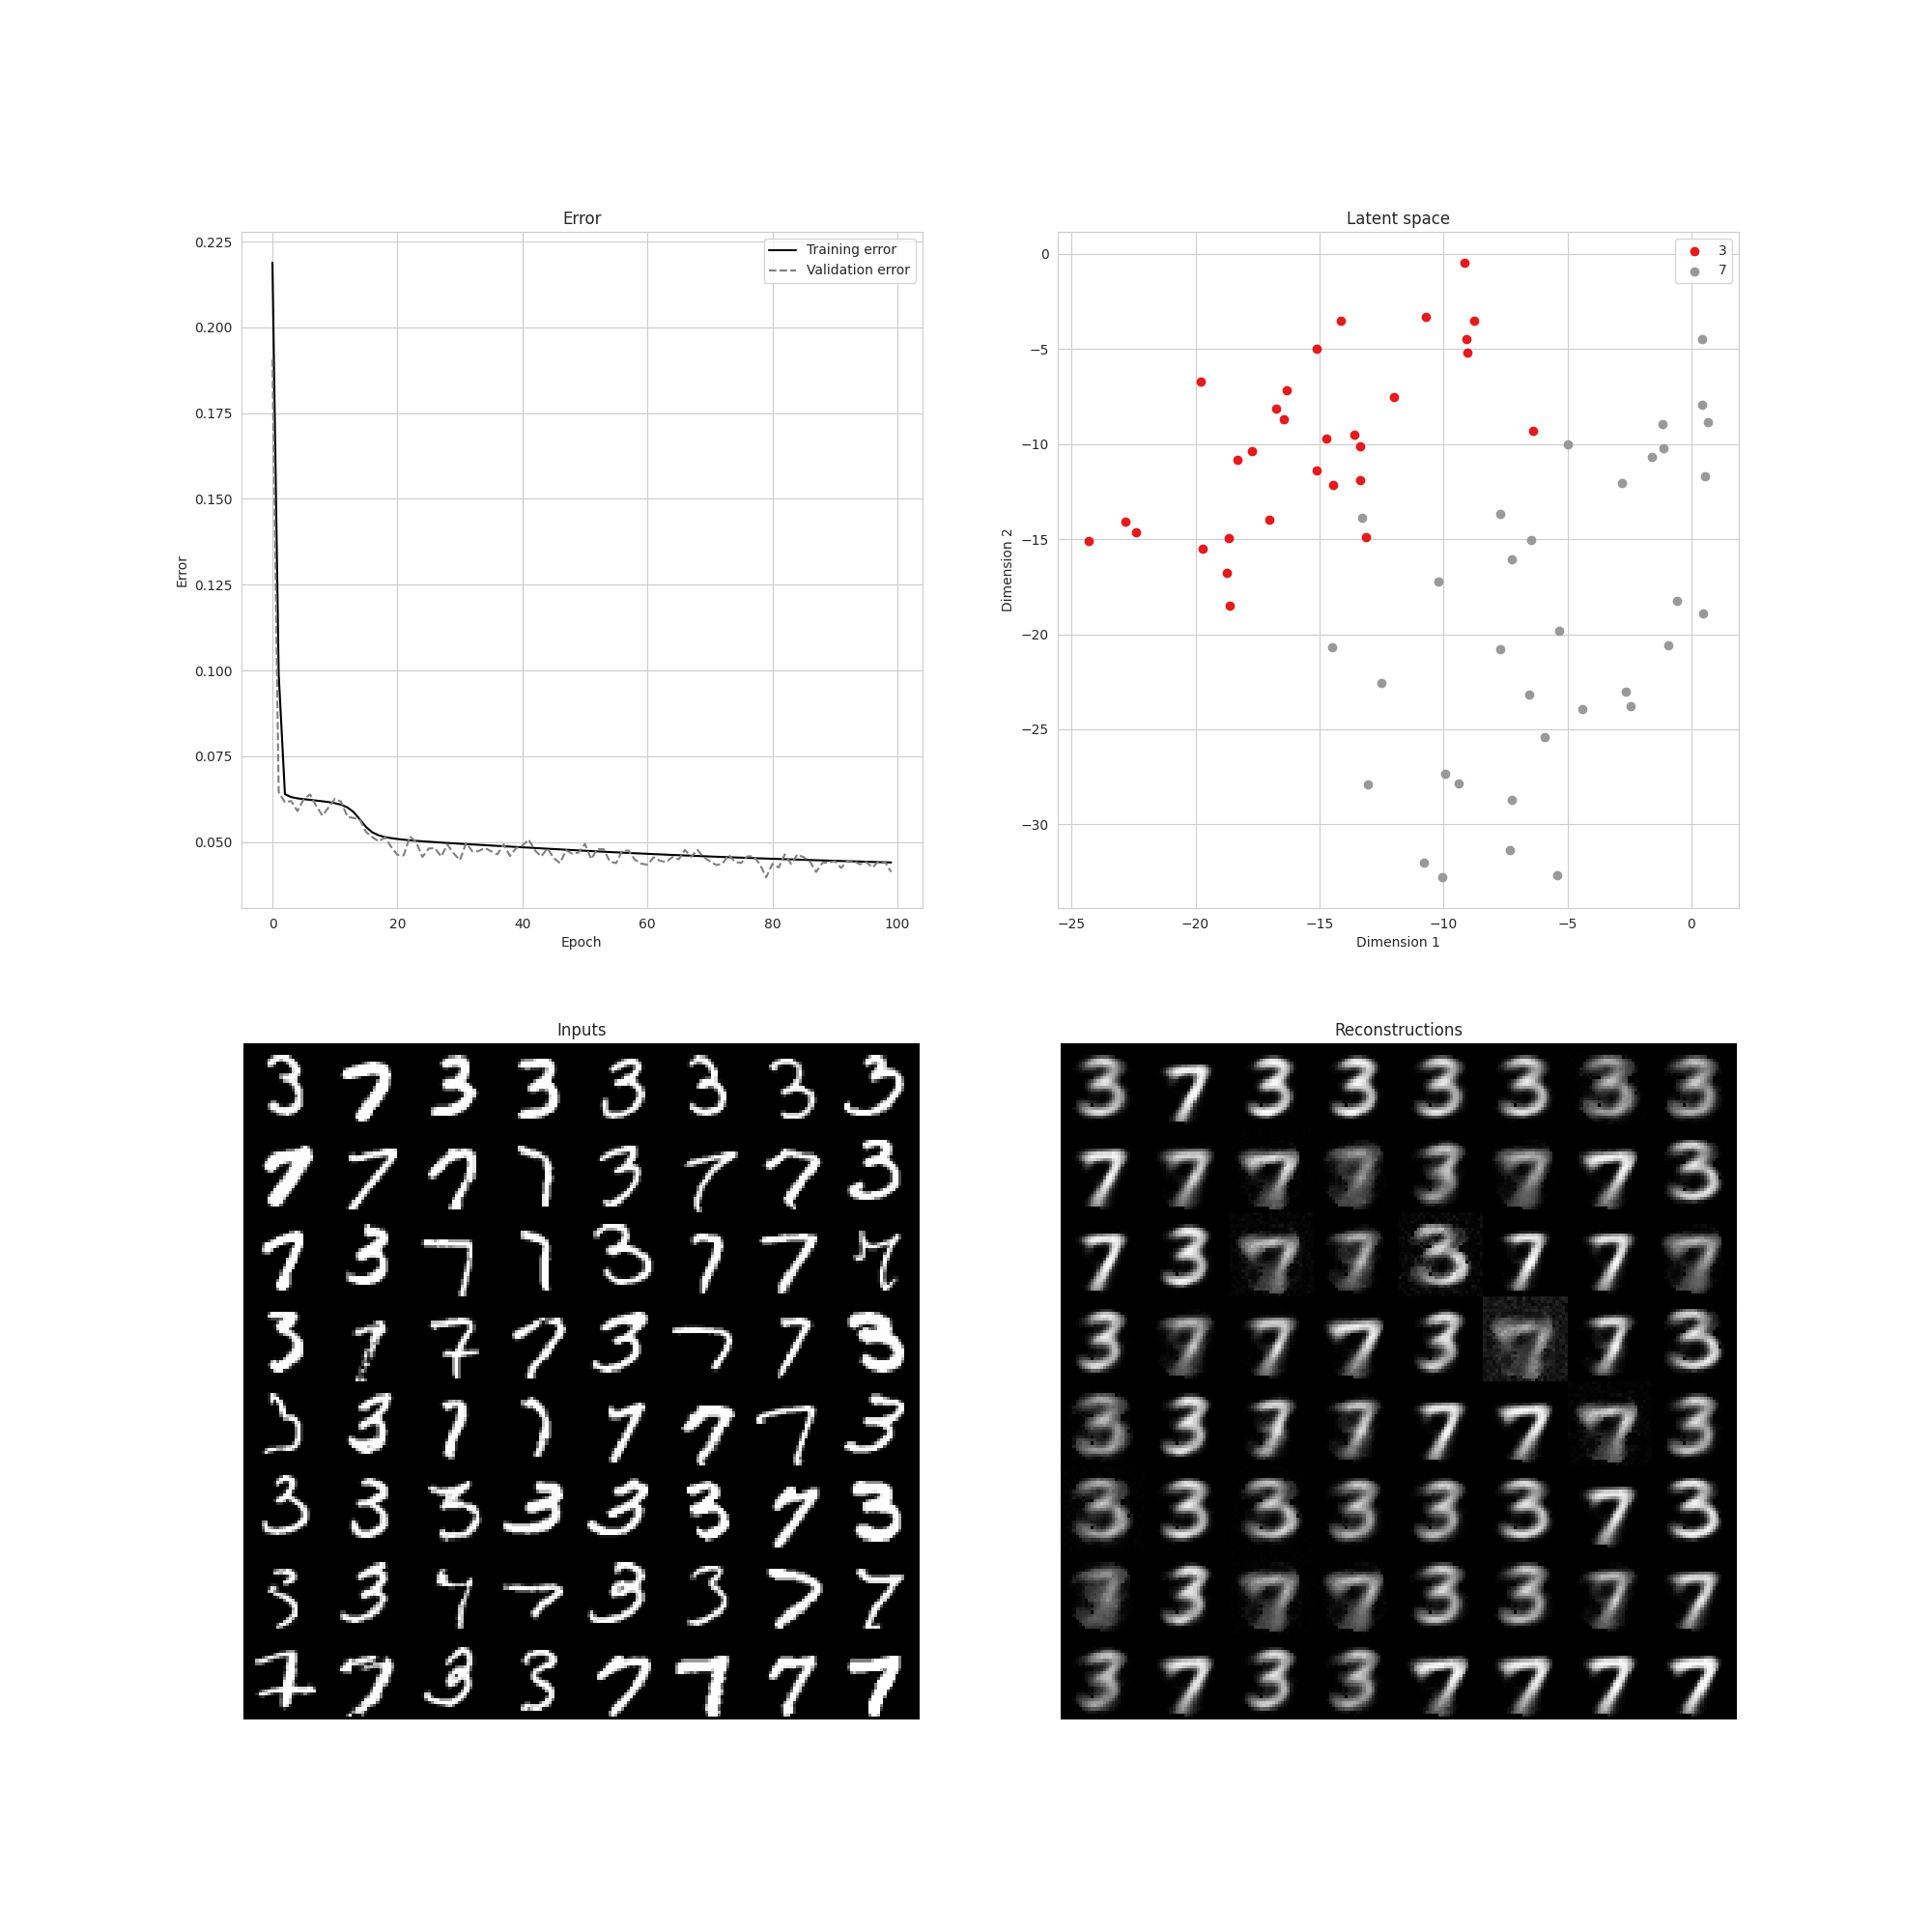

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

num_epochs = 100

train_loss = []
valid_loss = []

for epoch in range(num_epochs):
    batch_loss = []
    net.train()

    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, y in train_loader:

        if cuda:
            x = x.cuda()

        outputs = net(x)
        x_hat = outputs['x_hat']

        # note, target is the original tensor, as we're working with auto-encoders
        loss = loss_function(x_hat, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.item())

    train_loss.append(np.mean(batch_loss))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()

        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))

        if cuda:
            x = x.cuda()

        outputs = net(x)

        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x_hat = outputs['x_hat']
        z = outputs['z'].cpu().numpy()

        loss = loss_function(x_hat, x)

        valid_loss.append(loss.item())

    if epoch == 0:
        continue

    # live plotting of the trainig curves and representation
    plot_autoencoder_stats(x=x.cpu(),
                           x_hat=x_hat.cpu(),
                           z=z,
                           y=y,
                           train_loss=train_loss,
                           valid_loss=valid_loss,
                           epoch=epoch,
                           classes=classes,
                           dimensionality_reduction_op=None)


### Tarea 1 - Analizando el Autoencoder (AE)
1. La implementación anterior de un AE es muy simple.
    - Experimenta con el número de capas e intenta con diferentes no linealidades para mejorar las reconstrucciones.
    - ¿Qué sucede con la red cuando cambiamos las no linealidades en la capa latente (por ejemplo, sigmoide)?
    - Intenta aumentar el número de clases de dígitos en el conjunto de entrenamiento y analiza los resultados.
    - Opcional: Prueba diferentes algoritmos de optimización como ADAM y RMSProp, y decide si deberías usar regularizadores.
       
2. Actualmente optimizamos con respecto al error cuadrático medio (MSE).
    - Encuentra otra función de error que pueda adaptarse mejor a este problema.
    - Evalúa si la función de similitud $d$ es una mejor opción y explica tus hallazgos.

3. Complejidad del cuello de botella.
    - Aumenta el número de unidades en la capa latente y entrena el modelo.
    - Visualiza utilizando [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) o [UMAP](https://umap-learn.readthedocs.io/en/latest/).

## Tarea 2 - Añadiendo Clasificación para Aprendizaje Semi-Supervisado

El entrenamiento anterior se ha realizado de manera no supervisada. Ahora supongamos que solo tenemos una fracción de los puntos de datos etiquetados de cada clase. Como sabemos, el aprendizaje semi-supervisado se puede utilizar combinando el aprendizaje no supervisado y supervisado. Ahora debes analizar si un AE entrenado en el ejercicio anterior puede ayudar a un clasificador.

1. Construye un clasificador simple donde:
    - Entrena en el conjunto de datos etiquetados y evalúa los resultados.
2. Construye un segundo clasificador y entrena en la salida latente $\mathbf{z}$ del AE.
3. Construye un tercer clasificador y entrena en las reconstrucciones del AE.
4. Evalúa los clasificadores entre sí e implementa un modelo que mejore la clasificación combinando la entrada, la salida latente y la reconstrucción.

A continuación, proporcionamos algún código de inicio para usar solo un subconjunto de los datos etiquetados.


In [ ]:
def uniform_stratified_sampler(labels, classes, n=None):
    """
    Stratified sampler that distributes labels uniformly by
    sampling at most n data points per class
    """
    from functools import reduce
    # Only choose digits in n_labels
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))

    # Ensure uniform distribution of labels
    np.random.shuffle(indices)
    indices = np.hstack([list(filter(lambda idx: labels[idx] == i, indices))[:n] for i in classes])

    indices = torch.from_numpy(indices)
    sampler = SubsetRandomSampler(indices)
    return sampler


batch_size = 64

# Specify how many labelled examples we want per digit class
labels_per_class = 10

# Large pool of unlabelled data
unlabelled = DataLoader(dset_train, batch_size=batch_size,
                        sampler=stratified_sampler(dset_train.train_labels, classes=classes), pin_memory=cuda)

# Smaller pool of labelled data
labelled = DataLoader(dset_train, batch_size=batch_size,
                      sampler=uniform_stratified_sampler(dset_train.train_labels, classes=classes, n=labels_per_class),
                      pin_memory=cuda)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [ ]:
from itertools import cycle

# This is an example of how you can use both the labelled
# and unlabelled loader in unison

### Define your classifier ###

num_epochs = 100
for epoch in range(num_epochs):

    # Go through both labelled and unlabelled data
    for (x, y), (u, _) in zip(cycle(labelled), unlabelled):

        if cuda:
            x, y, u = x.cuda(), y.cuda(), u.cuda()

        # Send labelled data through autoencoder
        outputs = net(x)

        ### Define your loss function ###
        loss = 0

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

AttributeError: 'int' object has no attribute 'backward'